In [ ]:
#Clean and preprocess the Credit Card Fraud detection dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler

#Load the dataset
df = pd.read_csv('creditcard.csv')

#Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [ ]:
if df.isnull().sum().sum() == 0:
  print ("No missing values detected.")
else:
  #handle missing values (if any)
  df.fillna(0, inplace=True) #Replace NaNs with 0s or another appropriate value




In [ ]:
# Check for Duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
  df.drop_duplicates(inplace=True)
  print("Duplicates removed.")

Number of duplicate rows: 884
Duplicates removed.


In [ ]:
# Normalize the Amount and Time colums
#Amount normalization
scaler = StandardScaler()
df['Normalized_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.drop('Amount', axis=1, inplace=True)

#Time normalization
df['Normalized_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop('Time', axis=1, inplace=True)

In [ ]:
# Confirm Data types
print("Dataset information after preprocessing:\n")
print(df.info())

Dataset information after preprocessing:

<class 'pandas.core.frame.DataFrame'>
Index: 238789 entries, 0 to 239672
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   V1                 238789 non-null  float64
 1   V2                 238789 non-null  float64
 2   V3                 238789 non-null  float64
 3   V4                 238789 non-null  float64
 4   V5                 238789 non-null  float64
 5   V6                 238789 non-null  float64
 6   V7                 238789 non-null  float64
 7   V8                 238789 non-null  float64
 8   V9                 238789 non-null  float64
 9   V10                238789 non-null  float64
 10  V11                238789 non-null  float64
 11  V12                238789 non-null  float64
 12  V13                238789 non-null  float64
 13  V14                238789 non-null  float64
 14  V15                238789 non-null  float64
 15  V16           

In [ ]:
#Feature Engineering: Transaction Velocity
#Calculate transaction velocity as the number of transactions per user within
# a rolling time window
#For simplicity, assuming 'USER_ID' column exists
#Here, we simulate by creating random user IDs
import numpy as np
np.random.seed(42)
df['User_ID'] = np.random.randint(1,101, size=len(df)) #Generate dummy user IDs

#Group by 'User_ID' and calculate transaction velocity (number of transactions
# in a 1-hour window)
df['Transaction_Hour'] = df['Normalized_Time'] // 1 # Convert time into hourly bins
df['Transaction_Velocity'] = df.groupby(['User_ID', 'Transaction_Hour'])['Class'].transform('count')


In [ ]:
#Feature Engineering: Merchant Category Anomalies
#For this feature, assume we have a 'Merchant_Category' column
#If not present, simulate merchant categories
categories = ['Electronics', 'Travel', 'Grocery', 'Clothing', 'Entertainment']
df['Merchant_Category'] = np.random.choice(categories, size=len(df)) #Generate random categories

#Count frequency of each merchant category for fraudulent transactions
fraud_counts = df[df['Class'] == 1]['Merchant_Category'].value_counts()
df['Category_Anomaly'] = df['Merchant_Category'].apply(lambda x: fraud_counts.get(x,0))

In [ ]:
# Review New Features
print(df[['Normalized_Amount', 'Normalized_Time', 'Transaction_Velocity','Category_Anomaly']].head())

   Normalized_Amount  Normalized_Time  Transaction_Velocity  Category_Anomaly
0           0.231092        -1.996627                   449                78
1          -0.350401        -1.996627                   436                87
2           1.137543        -1.996603                   474                73
3           0.127719        -1.996603                   428                73
4          -0.084053        -1.996578                   416                73


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

#Encoding the Categorical Variables (Merchant category)
df = pd.get_dummies(df, columns=['Merchant_Category'], drop_first=True)

#Separate features and target
X = df.drop('Class', axis=1) #Features
y = df['Class'] #Target

#Check class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y))

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Check class distribution after SMOTE
print("Class distribution after SMOTE: ", Counter(y_train_resampled))

#Save the resampled dataset for SHAP analysis
X_train_resampled['Class'] = y_train_resampled
X_train_resampled.to_csv("creditcard_train_resampled.csv", index=False)
print("Balanced training dataset saved as creditcard_train_resampled.csv")


Class distribution before SMOTE: Counter({0.0: 238371, 1.0: 418})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE:  Counter({0.0: 190697, 1.0: 190697})
Balanced training dataset saved as creditcard_train_resampled.csv


In [ ]:
#Build baseline models using Logistic Regression and Decision Tress for fraud detection
#These models will help establish initial performance benchmarks on the dataset.

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#Separea feartures and target
X = df.drop('Class', axis=1)
y = df['Class']

#Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test, = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# ----Baseline Model 1: Logistic Regression ----
print("\n--- Logistic Regression ---")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

#Predictions and evaulation
y_pred_log = log_reg.predict(X_test)
y_pred_prob_log = log_reg.predict_proba(X_test)[:,1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob_log))

# ---- Baseline Model 2: Decision Tree ----
print("\n--- Decision Tree ---")
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

#Predictions and evaluation

y_pred_tree = decision_tree.predict(X_test)
y_pred_prob_tree = decision_tree.predict_proba(X_test)[:, 1]
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob_tree))




--- Logistic Regression ---
Confusion Matrix:
 [[47666     8]
 [   27    57]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     47674
         1.0       0.88      0.68      0.77        84

    accuracy                           1.00     47758
   macro avg       0.94      0.84      0.88     47758
weighted avg       1.00      1.00      1.00     47758

AUC-ROC Score: 0.9792312171753798

--- Decision Tree ---
Confusion Matrix: 
 [[47644    30]
 [   18    66]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     47674
         1.0       0.69      0.79      0.73        84

    accuracy                           1.00     47758
   macro avg       0.84      0.89      0.87     47758
weighted avg       1.00      1.00      1.00     47758

AUC-ROC Score: 0.8925425059481358


In [ ]:
#Lets begin with Advanced Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# ---- Model 1: Random Forest ---
print("\n---- Random Forest ----")
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

#Predictions and evaluation
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("AUC_ROC Score:", roc_auc_score(y_test, y_pred_prob_rf))

# ---- Model 2: XGBoost ----
print("\n---- XGBoost ----")
xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

#Predictions and evaluation
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:,1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC_ROC Score:", roc_auc_score(y_test, y_pred_prob_xgb))

# --- Model 3: Isolation Forest (Anomaly Detection) ---
print("\n ----Isolation Forest (Anomaly Detection) ----")
iso_forest = IsolationForest(random_state=42, contamination=0.02, n_estimators=100)
iso_forest.fit(X_train)

#Predictions for Isolation Forest (1 for normal, -1 for anomalies)
y_pred_iso = iso_forest.predict(X_test)
# convert -1 to 1 (fraudulent) and 1 to 0 (Legitimate)
y_pred_iso = [1 if pred == -1 else  0 for pred in y_pred_iso]

#Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_iso))
print("Classification Report:\n", classification_report(y_test, y_pred_iso))



---- Random Forest ----
Confusion Matrix:
 [[47666     8]
 [   27    57]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     47674
         1.0       0.88      0.68      0.77        84

    accuracy                           1.00     47758
   macro avg       0.94      0.84      0.88     47758
weighted avg       1.00      1.00      1.00     47758

AUC_ROC Score: 0.97479720902079

---- XGBoost ----


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:36:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[47670     4]
 [   13    71]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     47674
         1.0       0.95      0.85      0.89        84

    accuracy                           1.00     47758
   macro avg       0.97      0.92      0.95     47758
weighted avg       1.00      1.00      1.00     47758

AUC_ROC Score: 0.9908225907302972

 ----Isolation Forest (Anomaly Detection) ----
Confusion Matrix:
 [[46736   938]
 [   17    67]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     47674
         1.0       0.07      0.80      0.12        84

    accuracy                           0.98     47758
   macro avg       0.53      0.89      0.56     47758
weighted avg       1.00      0.98      0.99     47758



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:36:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Generating SHAP Summary Plot ...


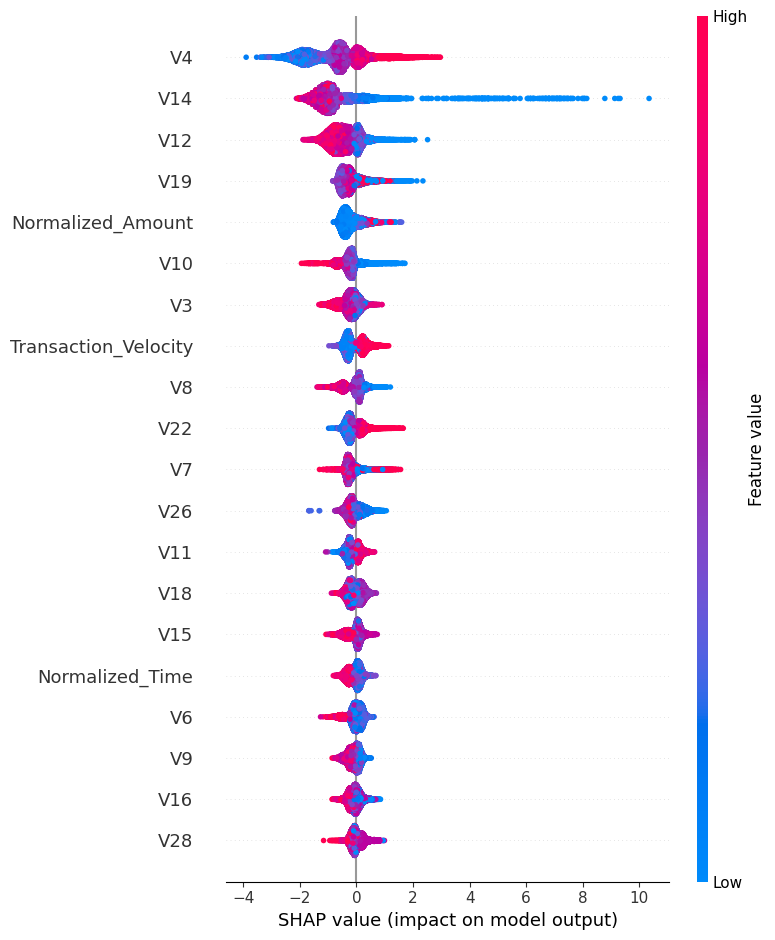


 Generating SHAP Bar plot for Feature Importance ...


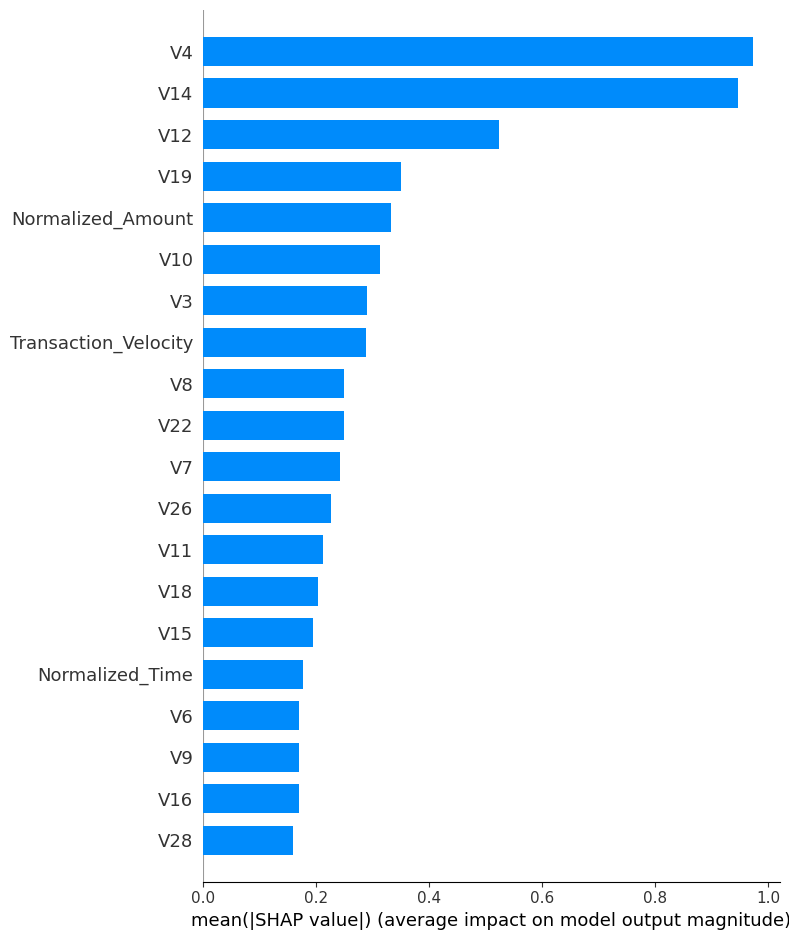


 Generating SHAP Dependence Plot for 'Normalized_Amount'...


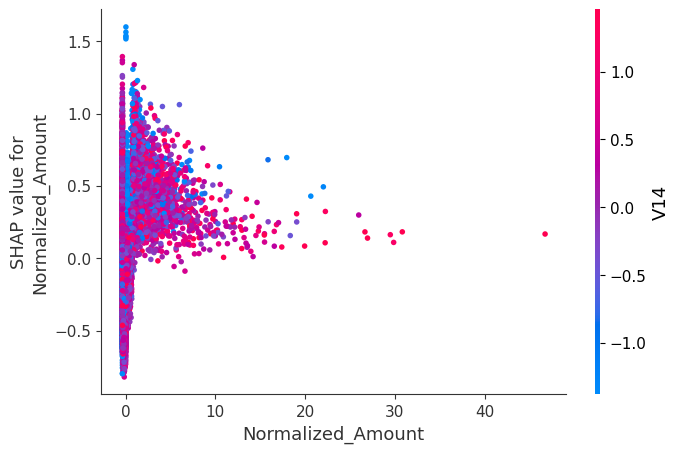


 Generating SHAP Force Plot for a single instance...


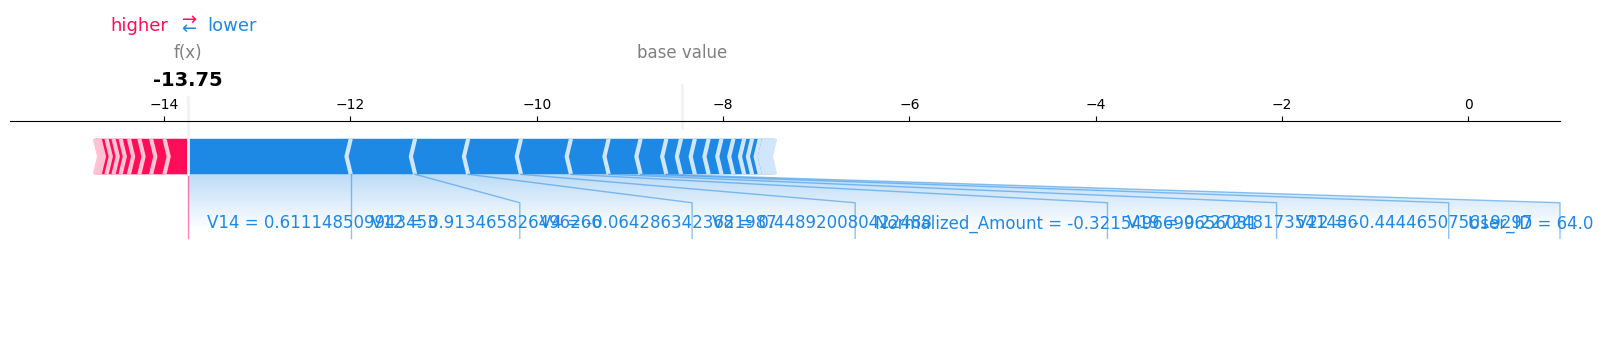

In [ ]:
#SHAP (SHapley Additive exPlanations) to analyze feature importance
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

#Train on XGBoost model
xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

#Create a SHAP explainer for the XGBoost model
explainer =shap.TreeExplainer(xgb)

#Compute SHAP values for the test dataset
shap_values =explainer.shap_values(X_test)

# --- SHAP Summary Plot ---
print("\n Generating SHAP Summary Plot ...")
shap.summary_plot(shap_values, X_test)

# --- SHAP Bar Plot for Feature Importance ---
print("\n Generating SHAP Bar plot for Feature Importance ...")
shap.summary_plot(shap_values, X_test, plot_type="bar")

#--- SHAP Dependence Plot ---
print("\n Generating SHAP Dependence Plot for 'Normalized_Amount'...")
shap.dependence_plot('Normalized_Amount', shap_values,X_test)

#--- SHAP Force Plot ---
print("\n Generating SHAP Force Plot for a single instance...")
instance_index=0
shap.force_plot(explainer.expected_value, shap_values[instance_index,:], X_test.iloc[instance_index,:],matplotlib=True)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:36:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


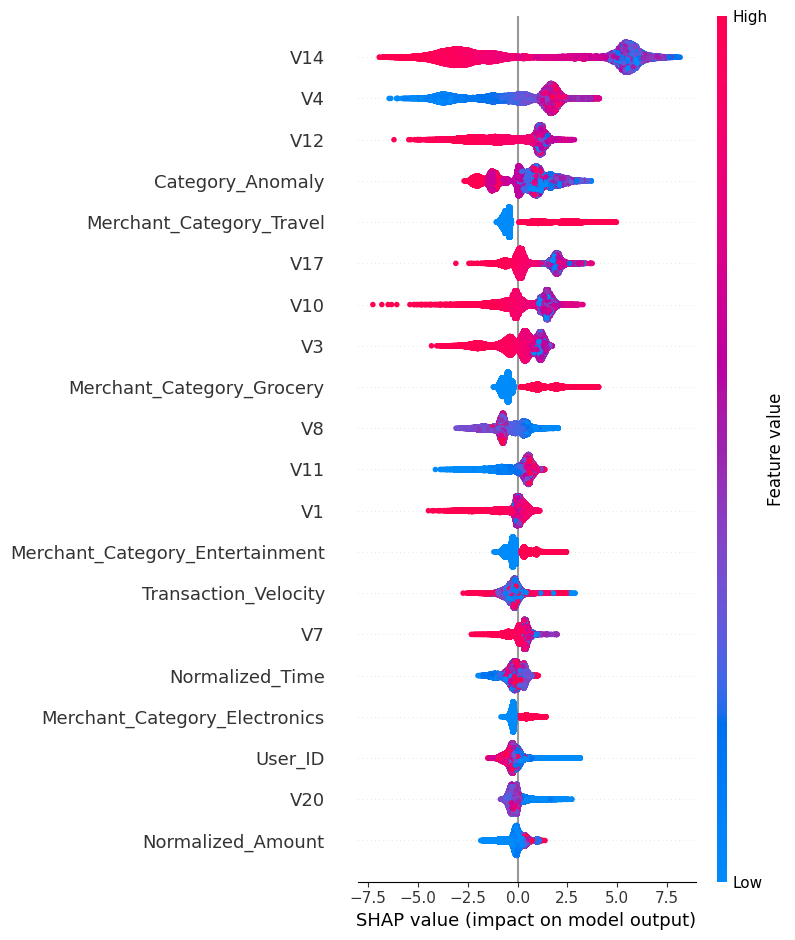

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

#Load the preprocessed dataset from the SMOTE application step
df=pd.read_csv('creditcard_train_resampled.csv')

#Split features and target
X = df.drop("Class", axis=1)
y= df["Class"]

#Split the data into training and testing sets (80% train and 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Train an XGBoost model on the training data
xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train,y_train)

#Create SHAP explainer and compute SHAP values for the test data
explainer =shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

#Generate SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_test)


Confusion Matrix:
 [[38128    12]
 [    0 38139]]
SHAP summary plot for correctly classified instances


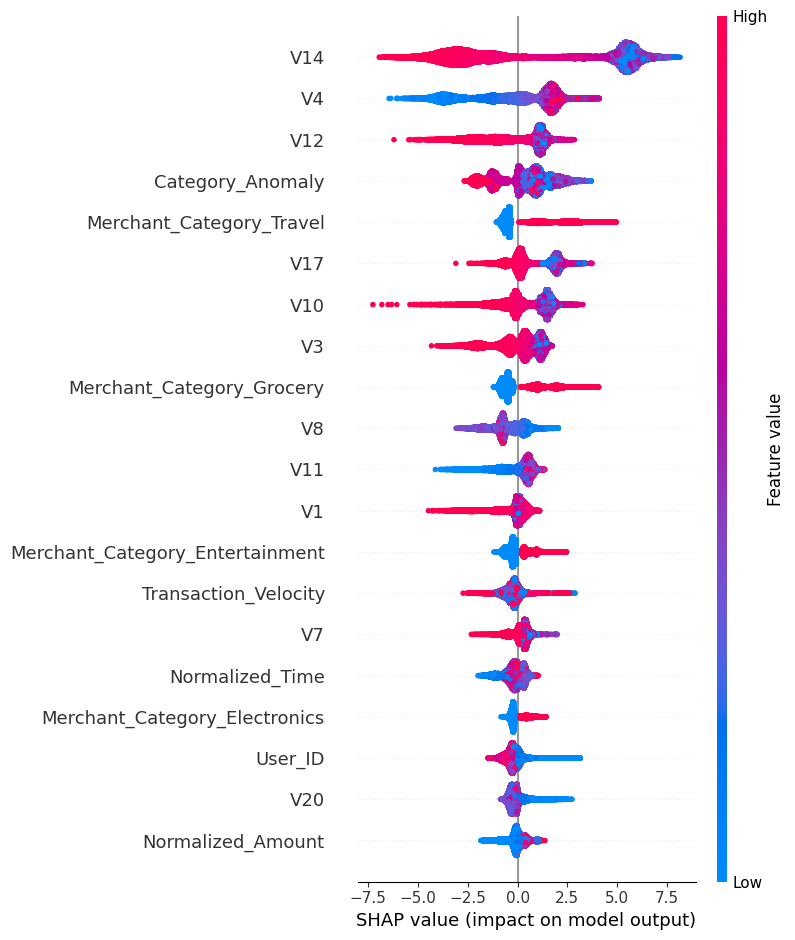

SHAP summary plot for misclassified instances


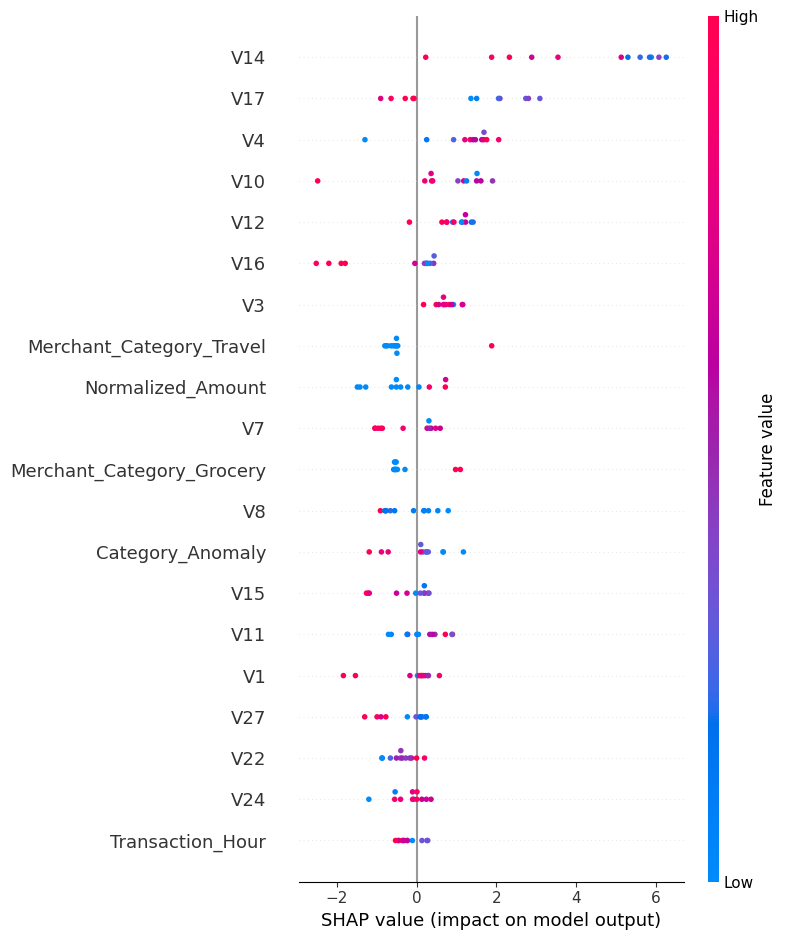

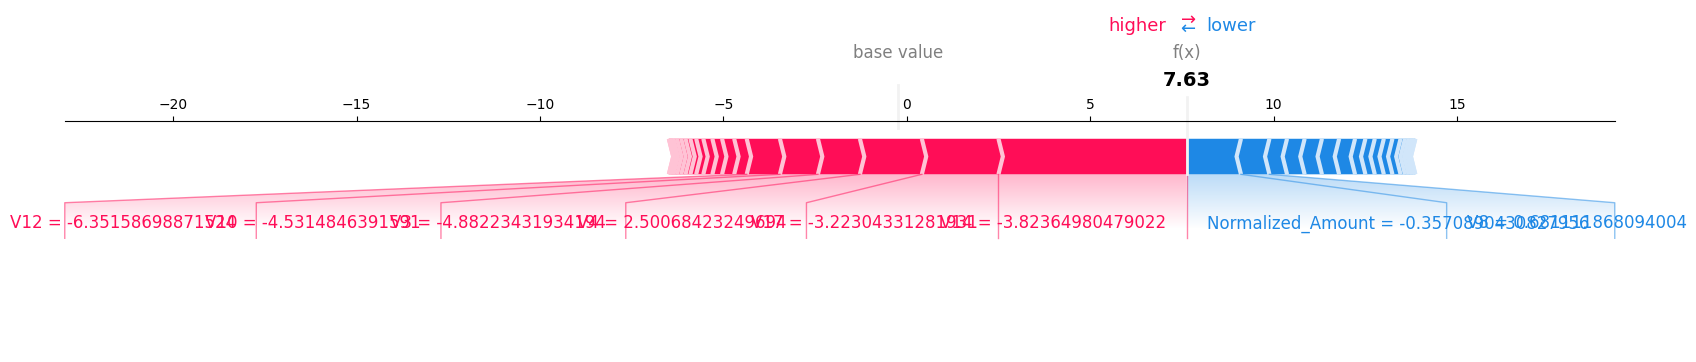

In [ ]:
# Lets analyze both correctly classified and misclassified instances using SHAP
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#lets use the X_test and y_test files from the previous step and generate
#predictions for the dataset and identify correct classified and misclassified instances

#Model prediction
y_pred = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)[:,1]

#Identify correctly and misclassified instances
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

#Separate instances
correct_indices = y_test.index[(y_test == y_pred)]
incorrect_indices = y_test.index[(y_test != y_pred)]

correct_samples = X_test.loc[correct_indices]
incorrect_samples = X_test.loc[incorrect_indices]

#Create SHAP explainer
explainer = shap.TreeExplainer(xgb)

#Compute SHAP values for correctly classified and misclassified instances
shap_values_correct = explainer.shap_values(correct_samples)
shap_values_incorrect = explainer.shap_values(incorrect_samples)

#Correctly classifed Instances
print("SHAP summary plot for correctly classified instances")
shap.summary_plot(shap_values_correct, correct_samples)

#Misclassifed Instances
print("SHAP summary plot for misclassified instances")
shap.summary_plot(shap_values_incorrect, incorrect_samples)

#Select a sample instance (replace index with a specific row ID)
sample_index = incorrect_indices[2]
shap.force_plot(
    explainer.expected_value,
    shap_values_incorrect[sample_index - incorrect_indices[2]],
    incorrect_samples.iloc[sample_index - incorrect_indices[2], :],
    matplotlib=True
)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:39:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Generating SHAP Summary Plot....


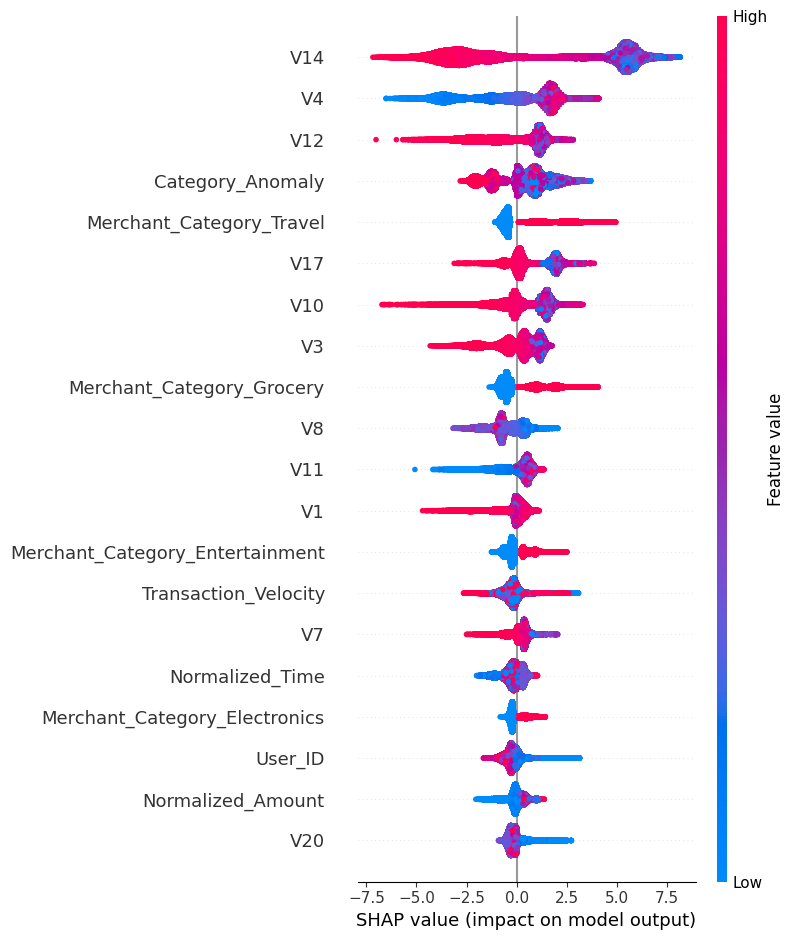


Top 5 Features Based on SHAP:
                     Feature  SHAP Importance
13                       V14         3.911543
3                         V4         1.769905
11                       V12         1.305617
33          Category_Anomaly         1.113980
37  Merchant_Category_Travel         0.957079

Retraining Model with Selected Features...


<ipython-input-16-ae6236ace75d>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected['Velocity_Amount_Ratio'] = X_train['Transaction_Velocity']/(X_train['Normalized_Amount'] + 1e-5)
<ipython-input-16-ae6236ace75d>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_selected['Velocity_Amount_Ratio'] = X_test['Transaction_Velocity']/(X_test['Normalized_Amount'] + 1e-5)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:45:18] WARNING: /workspace/src/learner.cc:740


Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38140
         1.0       1.00      1.00      1.00     38139

    accuracy                           1.00     76279
   macro avg       1.00      1.00      1.00     76279
weighted avg       1.00      1.00      1.00     76279

AUC-ROC Score: 0.9999555203867266


In [ ]:
# Let us refine the model using the SHAP results to improve its performance by
# identifying key features, understanding their influence, and addressing areas
# of weakness.

#This code includes feature selection based on SHAP importance values,
#feature engineering for high-impact interactions and model training

import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

#load the preprocessed dataset
df = pd.read_csv('creditcard_train_resampled.csv')

#Split features and target
X = df.drop('Class', axis=1)
Y = df['Class']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

#Step 1: Train Initial Model
xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

#Step 2: SHAP Analysis for Feature Importance
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

#SHAP summary Plot for Initial Model
print("\n Generating SHAP Summary Plot....")
shap.summary_plot(shap_values, X_train)

#Step 3: Feature Selection
#Calculate mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Importance': shap_importance
    }).sort_values(by='SHAP Importance', ascending=False)

print("\nTop 5 Features Based on SHAP:")
print(shap_importance_df.head())

#Select top features
top_features = shap_importance_df['Feature'].head(5).tolist()
#Enusre 'Transaction_Veloctiy is included in the selected features
if 'Transaction_Velocity' not in top_features:
  top_features.append('Transaction_Velocity')

#Create refined training and testing sets with the selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

#Step 4: Feature Engineering (SHAP Interaction Insights)
#Create interaction features if SHAP indicates relationships
X_train_selected['Velocity_Amount_Ratio'] = X_train['Transaction_Velocity']/(X_train['Normalized_Amount'] + 1e-5)
X_test_selected['Velocity_Amount_Ratio'] = X_test['Transaction_Velocity']/(X_test['Normalized_Amount'] + 1e-5)

#Step 5: Retrain the model with Refined Features
print("\nRetraining Model with Selected Features...")
xgb_refined = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_refined.fit(X_train_selected,y_train)

#Step 6: Evaluate the Refined Model
y_pred = xgb_refined.predict(X_test_selected)
y_pred_prob = xgb_refined.predict_proba(X_test_selected)[:,1]

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))


In [ ]:
# Let us train the model with the refined dataset and evaluate its performance
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

#Train the model on the refined dataset
xgb_refined= XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_refined.fit(X_train_selected, y_train)

#Predict on the test set
y_pred_refined = xgb_refined.predict(X_test_selected)
y_pred_prob_refined = xgb_refined.predict_proba(X_test_selected)[:,1]

#Evaluate the refined model
print("\nRefined Model Classification Report:")
print(classification_report(y_test, y_pred_refined))

print("Refined Model AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob_refined))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:45:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Refined Model Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38140
         1.0       1.00      1.00      1.00     38139

    accuracy                           1.00     76279
   macro avg       1.00      1.00      1.00     76279
weighted avg       1.00      1.00      1.00     76279

Refined Model AUC-ROC Score: 0.9999555203867266


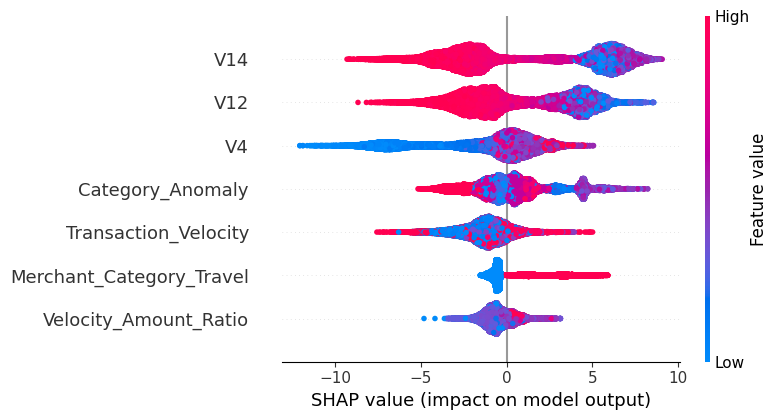


 Analyzing the impact of Transaction_Velocity


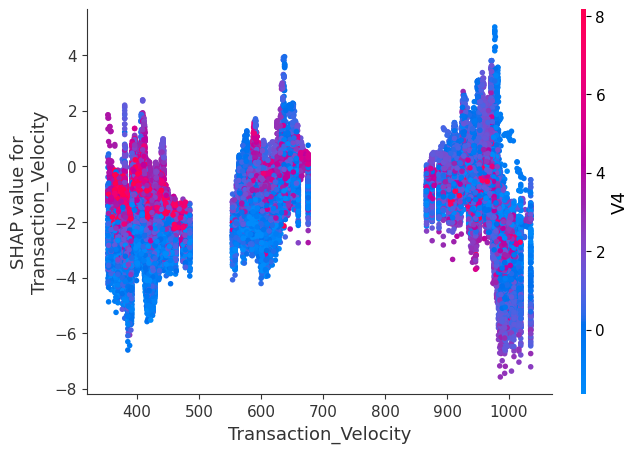


 Analyzing the impact of Velocity_Amount_Ratio


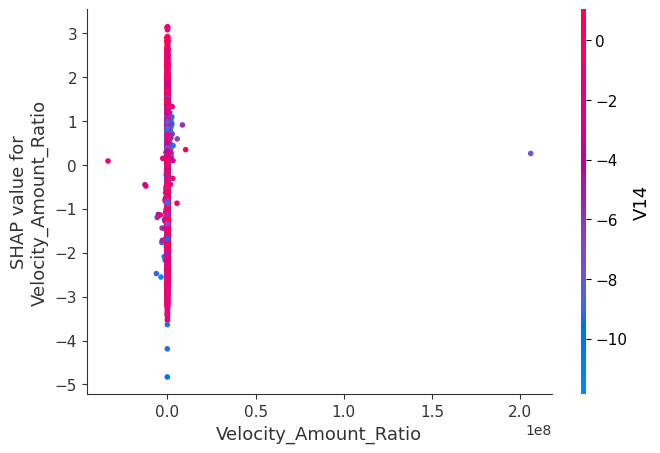

In [ ]:
#Analyze the Impact of Transaction_Velocity and Velocity_Amount_Ratio Using SHAP
import shap
import matplotlib.pyplot as plt

#Create SHAP explainer for the refined model
explainer_refined = shap.TreeExplainer(xgb_refined)
shap_values_refined = explainer_refined.shap_values(X_test_selected)

#SHAP Summary Plot for the Refined model
shap.summary_plot(shap_values_refined, X_test_selected)

#SHAP Dependence Plot for Transaction Velocity
print("\n Analyzing the impact of Transaction_Velocity")
shap.dependence_plot("Transaction_Velocity", shap_values_refined, X_test_selected)

#SHAP Dependence Plot for Velocity_Amount_Ratio
print("\n Analyzing the impact of Velocity_Amount_Ratio")
shap.dependence_plot("Velocity_Amount_Ratio", shap_values_refined, X_test_selected)


Compare Metrics Between Initial and Refinded Models

Metric            Initial Model     Refined Model
Precision(Fraud)   
Recall(Fraud)
F1-Score(Fraud)
AUC-ROC Score



 Initial Isolation Forest Performance:
Confusuin Matrix:
 [[190550    147]
 [183217   7480]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      1.00      0.68    190697
         1.0       0.98      0.04      0.08    190697

    accuracy                           0.52    381394
   macro avg       0.75      0.52      0.38    381394
weighted avg       0.75      0.52      0.38    381394


 Generating SHAP Summary Plot


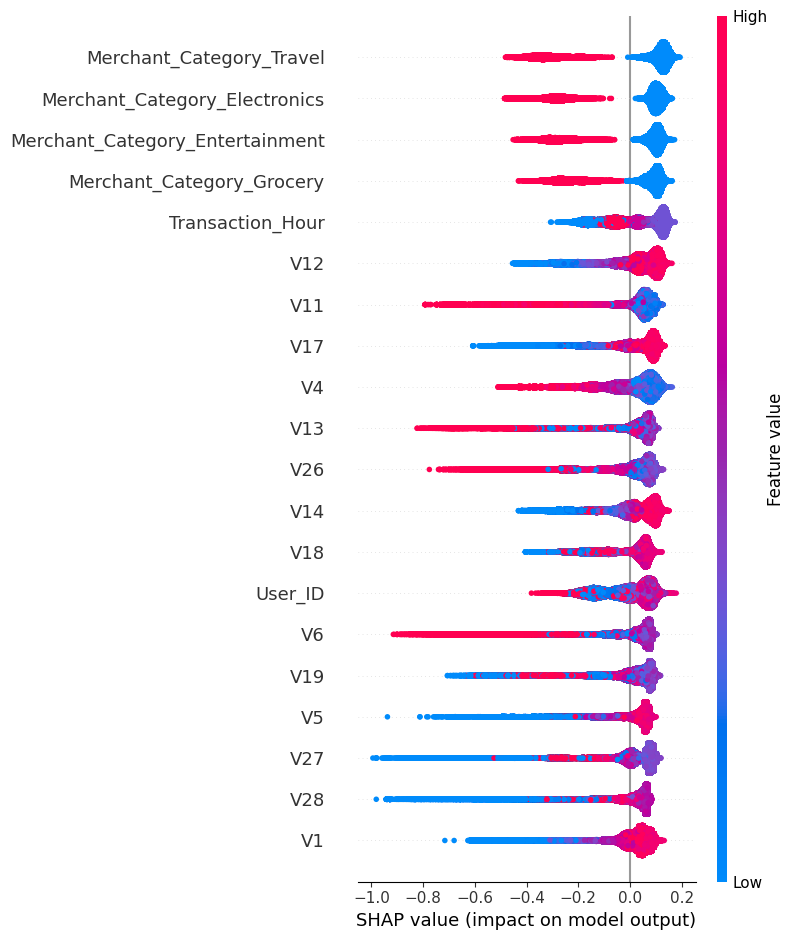


Top Features Based on SHAP:
                            Feature  Mean SHAP Value
37         Merchant_Category_Travel         0.175138
34    Merchant_Category_Electronics         0.150831
35  Merchant_Category_Entertainment         0.149425
36        Merchant_Category_Grocery         0.134867
31                 Transaction_Hour         0.096545

 Refined Isolation Forest Performance:
Confusion Matrix:
 [[190697      0]
 [185799   4898]]


In [ ]:
# Let us build the refined Isolation forest model using the SHAP
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

#Load the dataset
df = pd.read_csv("creditcard_train_resampled.csv")

#Split features and target
X = df.drop("Class", axis=1)
y = df["Class"]

#Train an Isolation Forest Model
iso_forest = IsolationForest(random_state=42, n_estimators=100, contamination=0.02)
iso_forest.fit(X)

#Get anomaly scores (higher scores mean higher likelihood of being fraud)
anomaly_scores = iso_forest.decision_function(X)
predictions = iso_forest.predict(X)

#Convert predictions: Isolation Forest returns -1 for anomalies, 1 for normal
predictions = [1 if pred == -1 else 0 for pred in predictions]

#Evaluate initial model
print("\n Initial Isolation Forest Performance:")
print("Confusuin Matrix:\n", confusion_matrix(y,predictions))
print("Classification Report:\n", classification_report(y, predictions))

#SHAP Explainer for Isolation Forest
explainer = shap.TreeExplainer(iso_forest, feature_perturbation='interventional')
shap_values = explainer.shap_values(X)

#SHAP Summary Plot
print("\n Generating SHAP Summary Plot")
shap.summary_plot(shap_values, X)

#Identify the top features using SHAP
shap_importance = pd.DataFrame({
    "Feature":X.columns,
    "Mean SHAP Value": abs(shap_values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

print("\nTop Features Based on SHAP:")
print(shap_importance.head())


#Select the top features
top_features = shap_importance['Feature'].head(5).tolist()

#Create refined feature set
X_refined = X[top_features]

#Retrain Isolation Forest with selected Features
iso_forest_refined = IsolationForest(random_state=42, n_estimators=100, contamination=0.02)
iso_forest_refined.fit(X_refined)

#Get refined anomaly scores and predictions
anomaly_scores_refined = iso_forest_refined.decision_function(X_refined)
predictions_refined = iso_forest_refined.predict(X_refined)
predictions_refined = [1 if pred == -1 else 0 for pred in predictions_refined]

#Evaluate refined model
print("\n Refined Isolation Forest Performance:")
print("Confusion Matrix:\n", confusion_matrix(y, predictions_refined))
print("Classification Report:\n", classification_report(y,predictions_refined))

#SHAP Summary plot for refined model
print("\n Generating SHAP Summary Plot for Refined Model")
shap_values_refined = explainer.shap_values(X_refined)
shap.summary_plot(shap_values_refined, X_refined)


In [ ]:
pip install --upgrade shap

In [ ]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load Dataset
df = pd.read_csv("creditcard_train_resampled.csv")

# Split Features and Target
X = df.drop("Class", axis=1)
y = df["Class"]

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Initial Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# SHAP Analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

# SHAP Summary Plot
print("\nGenerating SHAP summary plot...")
print("SHAP Values Shape:", shap_values[1].shape)
print("X_train Shape:", X_train.shape)
# shap.summary_plot(shap_values[1], X_train)  # Assuming class 1 (fraud focus)
# Recheck Columns
print("Columns in SHAP Data:", X_train.columns)
print("Columns Used by Model:", rf_model.feature_names_in_)
# Ensure Consistency
X_train = X_train[rf_model.feature_names_in_]
# Regenerate SHAP Values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
# Generate Summary Plot
shap.summary_plot(shap_values[1], X_train)

# # Identify Top Features Using SHAP
# shap_importance = pd.DataFrame({
#     "Feature": X_train.columns,
#     "Mean SHAP Value": np.abs(shap_values[1]).mean(axis=0)
# }).sort_values(by="Mean SHAP Value", ascending=False)

# print("\nTop Features Based on SHAP:")
# print(shap_importance.head(5))

# # Select Top Features
# top_features = shap_importance['Feature'].head(5).tolist()

# # Ensure Domain-Relevant Features Are Included
# essential_features = ['Transaction_Velocity', 'Category_Anomaly']
# for feature in essential_features:
#     if feature not in top_features:
#         top_features.append(feature)

# # Create Refined Datasets
# X_train_refined = X_train[top_features]
# X_test_refined = X_test[top_features]

# # Feature Engineering Example
# X_train_refined['Velocity_Amount_Ratio'] = X_train_refined['Transaction_Velocity'] / (X_train_refined['Normalized_Amount'] + 1e-5)
# X_test_refined['Velocity_Amount_Ratio'] = X_test_refined['Transaction_Velocity'] / (X_test_refined['Normalized_Amount'] + 1e-5)

# # Retrain Random Forest with Refined Dataset
# rf_refined_model = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_refined_model.fit(X_train_refined, y_train)

# # Evaluate Refined Model
# y_pred_rf_refined = rf_refined_model.predict(X_test_refined)
# y_pred_prob_rf_refined = rf_refined_model.predict_proba(X_test_refined)[:, 1]

# print("\n---- Refined Random Forest Performance -----")
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_refined))
# print("Classification Report:\n", classification_report(y_test, y_pred_rf_refined))
# print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob_rf_refined))

# # SHAP Analysis on Refined Model
# explainer_refined = shap.TreeExplainer(rf_refined_model)
# shap_values_refined = explainer_refined.shap_values(X_test_refined)

# print("\nGenerating SHAP summary plot for refined model...")
# shap.summary_plot(shap_values_refined[1], X_test_refined)


In [ ]:
pip install scikit-optimize

In [ ]:
#Hyperparameter Fine-Tuning
# Bayesian Optimization is more efficient than Grid Search as it focuses on
# promising hyperparameter regions instead of evaluating all combinations

#Bayesian Optimization with XGBoost
from skopt import BayesSearchCV

#Define search space
search_space = {
    'n_estimators': (50,200),
    'max_depth' : (3,10),
    'learning_rate' : (0.01,0.2, 'log-uniform'),
    'subsample': (0.6,1.0),
    'colsample_bytree': (0.6,1.0)
}

#Initialize Bayesian search
bayes_search = BayesSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    search_spaces=search_space,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

#Fit Bayesian search
bayes_search.fit(X_train, y_train)

#Output best parameters and model
print("Best Hyperparameters:", bayes_search.best_params_)
best_xgb_model = bayes_search.best_estimator_
